#### Most of the code taken from - https://www.tensorflow.org/tutorials/generative/pix2pix

# Import libs

In [ ]:
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import os

# Define global constants

In [ ]:
PATH_TO_DATA = "../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/"

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3


In [ ]:
PATH_TO_DATA1 = "../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/"
PATH_TO_DATA2 = "../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/"

In [ ]:
NUM_OF_DATA = len(glob.glob(os.path.join(PATH_TO_DATA1, "*")))
NUM_OF_DATA_TEST = len(glob.glob(os.path.join(PATH_TO_DATA2, "*")))

In [ ]:
NUM_OF_DATA, NUM_OF_DATA_TEST

(800, 704)

# Define tools to load train/test data

In [ ]:
def read_input_and_real_image(index: int, is_test=False):

    path_real = index+".png"
    path_input = index+"_mask.png"
    train_real_path = os.path.join(PATH_TO_DATA1, path_real)
    train_input_path = os.path.join(PATH_TO_DATA2, path_input)

    train_real = tf.io.read_file(train_real_path)
    train_real = tf.io.decode_png(train_real)

    train_input = tf.io.read_file(train_input_path)
    train_input = tf.io.decode_png(train_input)

    return train_real,tf.image.grayscale_to_rgb(train_input)

### Test load

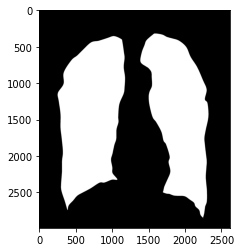

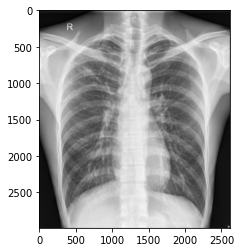

In [ ]:
single_input, single_real = read_input_and_real_image("CHNCXR_0662_1")
plt.figure()
plt.imshow(single_real)
plt.figure()
plt.imshow(single_input)

In [ ]:
single_real.shape

TensorShape([2988, 2619, 3])

In [ ]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
          stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (tf.cast(input_image, dtype=tf.float32) / 127.5) - 1
    real_image = (tf.cast(real_image, dtype=tf.float32) / 127.5) - 1

    return input_image, real_image


@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

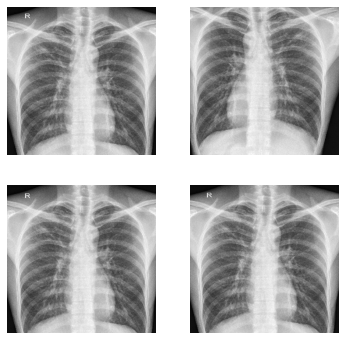

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_input, rj_real = random_jitter(single_input, single_real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_input)
    plt.axis('off')
plt.show()

### Define augs methods

In [ ]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/")
name_images = os.listdir(image_path)
name_mask = os.listdir(mask_path)
c=[]
for x in name_images:

    if x[:-4]+"_mask.png" in name_mask:
        c.append(x[:-4])
print(len(c))

566


In [ ]:
NUM_OF_DATA = 566

In [ ]:
NUM_OF_DATA_TEST = 566

In [ ]:
def data_generator(is_test=False):
    if is_test:
        max_number = NUM_OF_DATA
    else:
        max_number = NUM_OF_DATA

    counter = 1
    while True:
        input_image, real_image = read_input_and_real_image(c[counter-1])

        yield   resize(input_image, real_image,
        IMG_HEIGHT, IMG_WIDTH    )

        counter += 1
        if counter > max_number:
            counter = 1


def load_image_train(input_image, real_image):

    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


def load_image_test(input_image, real_image):
    input_image, real_image = resize(
        input_image, real_image,
        IMG_HEIGHT, IMG_WIDTH
    )
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

### Create dataset - tf pipeline

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(is_test=False),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8),
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8))
)
train_dataset = train_dataset.map(
    load_image_train, num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(NUM_OF_DATA)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [ ]:
BATCH_SIZE

1

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(is_test=True),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8),
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=tf.uint8))
)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
len(c)

566

### Test pipeline

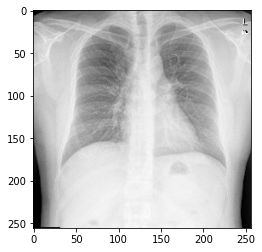

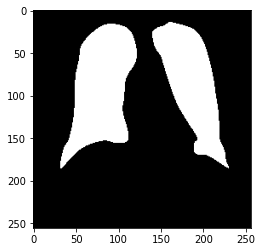

In [ ]:
input_image, real_image = next(iter(test_dataset))
plt.figure()
plt.imshow((input_image[0]+1)/2)
plt.figure()
plt.imshow((real_image[0]+1)/2)

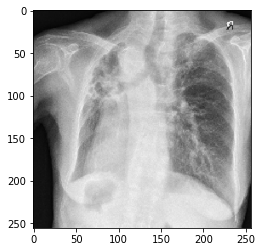

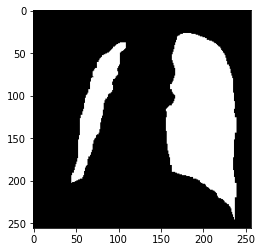

In [ ]:
input_image, real_image = next(iter(train_dataset))
plt.figure()
plt.imshow((input_image[0]+1)/2)
plt.figure()
plt.imshow((real_image[0]+1)/2)

# Define models

## Additional methods for some blocks

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(input_image)
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,padding='same',
            kernel_initializer=initializer,use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


## Generator model

In [ ]:
class Generator(tf.Module):

    def __init__(self):
        self.down_stack = [
            downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            downsample(128, 4),  # (batch_size, 64, 64, 128)
            downsample(256, 4),  # (batch_size, 32, 32, 256)
            downsample(512, 4),  # (batch_size, 16, 16, 512)
            downsample(512, 4),  # (batch_size, 8, 8, 512)
            downsample(512, 4),  # (batch_size, 4, 4, 512)
            downsample(512, 4),  # (batch_size, 2, 2, 512)
            downsample(512, 4),  # (batch_size, 1, 1, 512)
        ]

        self.up_stack = [
            upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            upsample(512, 4),  # (batch_size, 16, 16, 1024)
            upsample(256, 4),  # (batch_size, 32, 32, 512)
            upsample(128, 4),  # (batch_size, 64, 64, 256)
            upsample(64, 4),  # (batch_size, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(
            OUTPUT_CHANNELS, 4, strides=2,
            padding='same',kernel_initializer=initializer,
            activation='tanh'
        )  # (batch_size, 256, 256, 3)

    def __call__(self, x, training=False):
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = tf.concat([x, skip], axis=-1)
        x = self.last(x, training=training)
        return x

In [ ]:
generator = Generator()

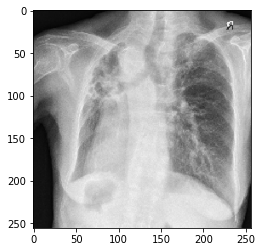

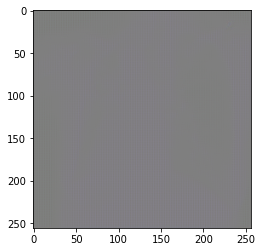

In [ ]:
gen_output = generator(input_image)
plt.figure()
plt.imshow((input_image[0]+1)/2)
plt.figure()
plt.imshow((gen_output[0]+1)/2)

### Generator loss

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [ ]:
class Discriminator(tf.Module):

    def __init__(self):
        initializer = tf.random_normal_initializer(0., 0.02)

        self.down1 = downsample(64, 4, False)  # (batch_size, 128, 128, 64)
        self.down2 = downsample(128, 4)  # (batch_size, 64, 64, 128)
        self.down3 = downsample(256, 4)  # (batch_size, 32, 32, 256)

        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()  # (batch_size, 34, 34, 256)
        self.conv = tf.keras.layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer,
            use_bias=False
        )  # (batch_size, 31, 31, 512)

        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.leaky_relu = tf.keras.layers.LeakyReLU()

        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()  # (batch_size, 33, 33, 512)

        self.last = tf.keras.layers.Conv2D(
            1, 4, strides=1,kernel_initializer=initializer
        )  # (batch_size, 30, 30, 1)

    def __call__(self, input_x, target_x, training=False):
        x = tf.concat([input_x, target_x], axis=-1)
        x = self.down1(x, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x, training=training)
        x = self.conv(x, training=training)
        x = self.batchnorm1(x, training=training)
        x = self.leaky_relu(x, training=training)
        x = self.zero_pad2(x, training=training)
        x = self.last(x, training=training)
        return x

In [ ]:
discriminator = Discriminator()

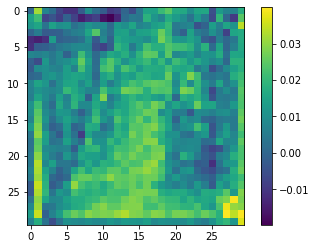

In [ ]:
disc_out = discriminator(gen_output, input_image)
plt.figure()
plt.imshow(disc_out[0])
plt.colorbar()

### Discriminator loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Define training stuff

### Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoint controller

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Additional test tools

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Test it

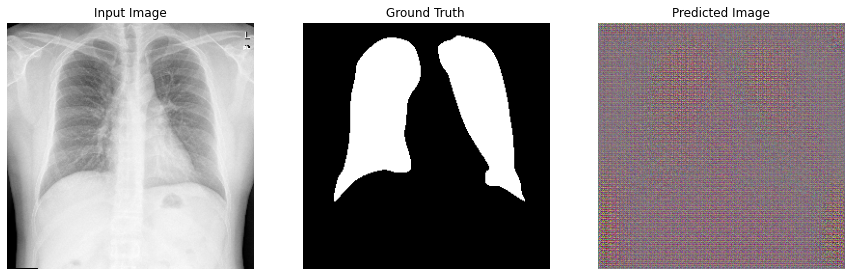

In [ ]:
for example_input, example_target in test_dataset.take(1):
      generate_images(generator, example_input, example_target)

### Create log file

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

## Step function - single training step

In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(input_image, target, training=True)
        disc_generated_output = discriminator(input_image, gen_output, training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

# Training

In [ ]:
import time
from IPython import display

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 178.98 sec



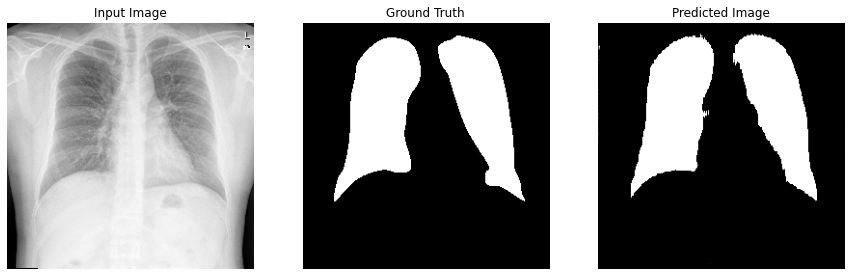

Step: 5k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=6000)